## Supplementary Figure 4

Describing percent strong results

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
get_scores <- function(file_indicator, assay = "cellpainting") {
    
    if (assay == "cellpainting") {
        pr_df <- load_percent_strong(
            assay = assay,
            results_dir = results_dir,
            cp_file_indicator = file_indicator
        )
    } else {
        pr_df <- load_percent_strong(
            assay = assay,
            results_dir = results_dir,
            l1000_file_indicator = file_indicator
        )
    }
    
    pr_df$dose <- factor(pr_df$dose, levels = dose_order)
    
    threshold_df <- pr_df %>%
        dplyr::filter(type == 'non_replicate') %>%
        dplyr::group_by(assay, dose) %>%
        dplyr::summarise(threshold = quantile(replicate_correlation, 0.95))

    percent_strong_df <- pr_df %>%
        dplyr::left_join(threshold_df, by = c("assay", "dose")) %>%
        dplyr::filter(type == "replicate") %>%
        dplyr::mutate(pass_threshold = threshold < replicate_correlation) %>%
        dplyr::group_by(dose, assay) %>%
        dplyr::summarize(percent_strong = 100 * (sum(pass_threshold) / length(pass_threshold))) %>%
        dplyr::ungroup()
    
    return(list("threshold" = threshold_df, "percent_strong" = percent_strong_df, "median_cor_distrib" = pr_df))
}

In [3]:
output_figure_base <- file.path("figures", "supplementary", "supfigure4")
extensions <- c(".png", ".pdf")

cp_values = c(
    "Cell Painting spherized" = "#332288",
    "Cell Painting subsampled" = "#117733",
    "Cell Painting nonspherized" = "#88CCEE",
    "L1000 spherized" = "#882255",
    "L1000 nonspherized" = "#AA4499"
)

In [4]:
results_dir <- file.path("../1.Data-exploration/Profiles_level4/results")

In [5]:
# Get percent strong scores
cp_file_indicator <- "_nonspherized"
non_spherized_info <- get_scores(cp_file_indicator)

cp_file_indicator <- "_subsample"
subsample_info <- get_scores(cp_file_indicator)

cp_file_indicator <- ""
standard_info <- get_scores(cp_file_indicator)

file_indicator <- ""
standard_info_l1000 <- get_scores(file_indicator=file_indicator, assay = "l1000")

file_indicator <- "_w"
spherized_l1000 <- get_scores(file_indicator=file_indicator, assay = "l1000")


# Extract and combine percent strong results
non_spherized_df <- non_spherized_info[["percent_strong"]] %>%
    dplyr::mutate(sample_type = "Cell Painting nonspherized")

subsampled_df <- subsample_info[["percent_strong"]] %>%
    dplyr::mutate(sample_type = "Cell Painting subsampled")

original_df <- standard_info[["percent_strong"]] %>%
    dplyr::mutate(sample_type = "Cell Painting spherized")

non_spherized_l1000_df <- standard_info_l1000[["percent_strong"]] %>%
    dplyr::mutate(sample_type = "L1000 nonspherized")

spherized_l1000_df <- spherized_l1000[["percent_strong"]] %>%
    dplyr::mutate(sample_type = "L1000 spherized")

pr_df <- dplyr::bind_rows(non_spherized_df, subsampled_df, original_df, non_spherized_l1000_df, spherized_l1000_df) %>%
    dplyr::mutate(percent_strong_round = paste0(round(percent_strong, 0), "%"))

print(dim(pr_df))
head(pr_df)

[1] 30  5


dose,assay,percent_strong,sample_type,percent_strong_round
<fct>,<chr>,<dbl>,<chr>,<chr>
0.04 uM,Cell Painting,56.35930,Cell Painting nonspherized,56%
0.12 uM,Cell Painting,59.61844,Cell Painting nonspherized,60%
0.37 uM,Cell Painting,60.89030,Cell Painting nonspherized,61%
1.11 uM,Cell Painting,67.48808,Cell Painting nonspherized,67%
3.33 uM,Cell Painting,70.27027,Cell Painting nonspherized,70%
10 uM,Cell Painting,70.90620,Cell Painting nonspherized,71%


In [6]:
non_spherized_pr_df <- non_spherized_info[["median_cor_distrib"]] %>%
    dplyr::mutate(sample_type = "Cell Painting nonspherized")

subsampled_pr_df <- subsample_info[["median_cor_distrib"]] %>%
    dplyr::mutate(sample_type = "Cell Painting subsampled")

original_pr_df <- standard_info[["median_cor_distrib"]] %>%
    dplyr::mutate(sample_type = "Cell Painting spherized")

non_spherized_l1000_pr_df <- standard_info_l1000[["median_cor_distrib"]] %>%
    dplyr::mutate(sample_type = "L1000 nonspherized")

spherized_l1000_pr_df <- spherized_l1000[["median_cor_distrib"]] %>%
    dplyr::mutate(sample_type = "L1000 spherized")

pr_distrib_df <- dplyr::bind_rows(non_spherized_pr_df, subsampled_pr_df, original_pr_df, non_spherized_l1000_pr_df, spherized_l1000_pr_df)

pr_distrib_df$sample_type <- factor(pr_distrib_df$sample_type, levels = paste(names(cp_values)))

print(dim(pr_distrib_df))
head(pr_distrib_df)

[1] 145830      5


dose,replicate_correlation,type,assay,sample_type
<fct>,<dbl>,<chr>,<chr>,<fct>
0.04 uM,0.5111332,replicate,Cell Painting,Cell Painting nonspherized
0.12 uM,0.3292485,replicate,Cell Painting,Cell Painting nonspherized
0.37 uM,0.2241790,replicate,Cell Painting,Cell Painting nonspherized
1.11 uM,0.2870330,replicate,Cell Painting,Cell Painting nonspherized
3.33 uM,0.3250922,replicate,Cell Painting,Cell Painting nonspherized
10 uM,0.8832692,replicate,Cell Painting,Cell Painting nonspherized


In [7]:
non_spherized_thresh_df <- non_spherized_info[["threshold"]] %>%
    dplyr::mutate(sample_type = "Cell Painting nonspherized")

subsampled_thresh_df <- subsample_info[["threshold"]] %>%
    dplyr::mutate(sample_type = "Cell Painting subsampled")

original_threshr_df <- subsample_info[["threshold"]] %>%
    dplyr::mutate(sample_type = "Cell Painting spherized")

non_spherized_l1000_thresh_df <- standard_info_l1000[["threshold"]] %>%
    dplyr::mutate(sample_type = "L1000 nonspherized")

spherized_l1000_thresh_df <- spherized_l1000[["threshold"]] %>%
    dplyr::mutate(sample_type = "L1000 spherized")

threshold_df <- dplyr::bind_rows(
    non_spherized_thresh_df, subsampled_thresh_df, original_threshr_df, non_spherized_l1000_thresh_df, spherized_l1000_thresh_df
)

threshold_df$sample_type <- factor(threshold_df$sample_type, levels =  paste(names(cp_values)))


print(dim(threshold_df))
head(threshold_df)

[1] 30  4


assay,dose,threshold,sample_type
<chr>,<fct>,<dbl>,<fct>
Cell Painting,0.04 uM,0.3031302,Cell Painting nonspherized
Cell Painting,0.12 uM,0.2771561,Cell Painting nonspherized
Cell Painting,0.37 uM,0.2870358,Cell Painting nonspherized
Cell Painting,1.11 uM,0.2631275,Cell Painting nonspherized
Cell Painting,3.33 uM,0.2767555,Cell Painting nonspherized
Cell Painting,10 uM,0.3677980,Cell Painting nonspherized


In [8]:
sup_fig3_top_gg <- (
    ggplot(pr_distrib_df, aes(x = replicate_correlation))
    + geom_density(aes(fill = type), alpha = 0.4)
    + facet_grid("sample_type~dose")
    + geom_vline(data = threshold_df, linetype = "dashed", color = "blue", aes(xintercept=threshold))
    + geom_text(data = pr_df, aes(label = percent_strong_round, x = 0.55, y = 8.5))
    + theme_bw()
    + figure_theme
    + theme(strip.text.y = element_text(size = 6))
    + scale_fill_manual("Correlations\nbetween", values = replicate_colors)
    + xlab("Median pairwise Pearson correlation")
    + ylab("Density")
)

In [9]:
sup_fig3_bottom_gg <- (
    ggplot(pr_df, aes(x = dose, y = percent_strong, fill = sample_type))
    + geom_bar(stat = "identity", position = "dodge")
    + xlab("Dose")
    + ylab("Percent strong")
    + scale_fill_manual(
        "Input data",
        values = cp_values
    )
    + figure_theme
)

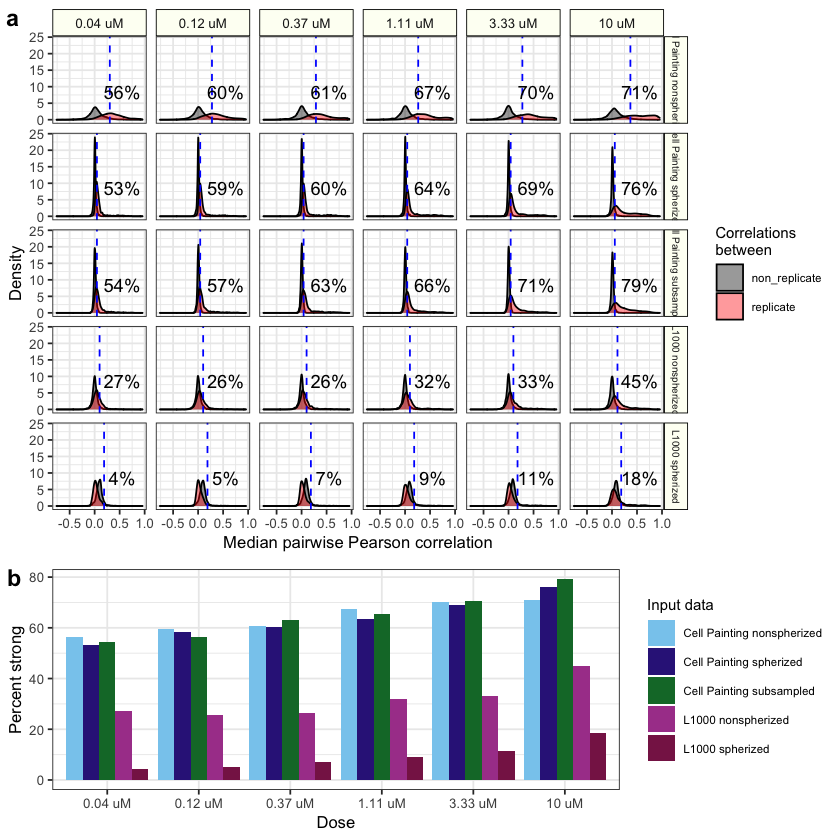

In [10]:
sup_fig3_gg <- cowplot::plot_grid(
    sup_fig3_top_gg,
    sup_fig3_bottom_gg,
    labels = c("a", "b"),
    rel_heights = c(1, 0.5),
    nrow = 2
)

sup_fig3_gg

In [11]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, sup_fig3_gg, base_width = 10, base_height = 10, dpi = 500)
}